# Car Review Sentiment Analysis

_Assignment for the University of Bath as part of MSc in Artificial Intelligence_ 

_Data Source: University of Bath dapertment of Computer Science_

## Initial Model

Firstly, we import the required modules and read the data using Pandas

In [1]:
import pandas as pd
import string
import seaborn as sn
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samjp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
with open("car-reviews.csv"):
    original_data = pd.read_csv("car-reviews.csv")
all_data = original_data.copy()
all_data[0:3]

,Sentiment,Review
0,Neg,In 1992 we bought a new Taurus and we really ...
1,Neg,The last business trip I drove to San Franci...
2,Neg,My husband and I purchased a 1990 Ford F250 a...


Before setting up the Naive Bayes model and predicting the sentiment of car reviews, we must perform some pre-processing on the raw text data of the reviews. 

The code below converts all text to lowercase, then removes punctuation and stopwords, and also uses NLTK's PorterStemmer to stem words so they can be grouped together in the model.

In [3]:
# lowercase

all_data["Review"] = all_data["Review"].str.lower()

# remove stopwords, punctuation and numbers. Then stem words.

stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation)
word_stemmer = PorterStemmer()

for i in range(0, len(all_data)):
    review_text = all_data.loc[i, "Review"]
    review_text = word_tokenize(review_text)
    cleaned_text = ""
    for item in review_text:
        if item not in stop_words and item not in punctuation:
            cleaned_text += word_stemmer.stem(item) + " "
    all_data.loc[i, "Review"] = cleaned_text
    
all_data[0:3]

,Sentiment,Review
0,Neg,1992 bought new tauru realli love 1999 decid t...
1,Neg,last busi trip drove san francisco went hertz ...
2,Neg,husband purchas 1990 ford f250 noth problem ow...


To show what the PorterStemmer has done, we can look at 3 stems and identify different variations which have been amalgamated:

In [4]:
def identify_words(stem, data):
    word_list = []
    for row in data:
        for word in row.split():
            if word[0:len(stem)] == stem and word not in word_list:
                word_list.append(word)
    return word_list

In [5]:
stems = ["check", "brake", "vehicle"]
data_1 = original_data["Review"]
data_2 = all_data["Review"]
for stem in stems:
    print("--------------------------------------------------------------")
    print(f"Original Data Set: {identify_words(stem, data_1)}")
    print(f"Processed Data Set: {identify_words(stem, data_2)}")

--------------------------------------------------------------
Original Data Set: ['check', 'checked', 'checklists', 'checking', 'checkup', 'checks', 'checkbook']
Processed Data Set: ['check', 'checklist', 'checkup', 'checkbook']
--------------------------------------------------------------
Original Data Set: ['brakes', 'brake', 'braked', 'brakeline', 'brakelight']
Processed Data Set: ['brake', 'brakelin', 'brakelight']
--------------------------------------------------------------
Original Data Set: ['vehicle', 'vehicles', 'vehiclee']
Processed Data Set: ['vehicle']


From this output we can see that these words have been stemmed correctly. In the first example "check", "checked", "checking" and "checks" have been stemmed to "check" (and "checklists" has been stemmend to "checklist"). In the second, "brakes", "brake" and "braked" have been stemmed to "brake". In the third, "vehicle", "vehicles" and a mis-spelling "vehiclee" have all been stemmed to "vehicle".

Now that the review data has been pre-processed, we split into training and testing datasets. 1106 rows are used for training (approx 80%) and the remaing rows are saved for testing the model. The Pandas .sample method randomly selects the training data (a random state of 1 is used here so the performance of the model can be compared to the alternative models.

In [6]:
training_data_size = 1106
training_data = all_data.sample(n=training_data_size, random_state=1)
testing_data = all_data.drop(training_data.index)
training_data

,Sentiment,Review
989,Pos,young singl person much need minivan check non...
991,Pos,first say 1995 extent 96 windstar suck reliabl...
1057,Pos,own ford econolin full size van regenc custom ...
1071,Pos,bought car brand new four year ago everyth wan...
60,Neg,bought 1997 tauru lx tom wood ford indianapoli...
...,...,...
476,Neg,fine go buy someth bigger nicer that told toyo...
781,Pos,say enough ford expedit own one past two year ...
454,Neg,dear reader think start sad note say never dar...
1249,Pos,95 ford contour realli great car anybodi run g...


Next, we use scikit-learn's feature extraction count vectorizer, which identifies all unique words across all reviews in the training set, then for each review, creates a vector of the counts of each word. This is then converted to a Pandas dataframe to be used as the feature matrix for the model. The Sentiment of the reviews is also stored in the train_y variable

In [7]:
vectorizer = CountVectorizer()
train_X = vectorizer.fit_transform(training_data["Review"])
train_X = pd.DataFrame(train_X.toarray(), columns=vectorizer.get_feature_names())
train_y = training_data["Sentiment"]
train_X

,00,000,0000,000k,000km,00a,00p,01,0110,02,...,zoom,zr,zt,ztec,ztech,ztw,zx,zx2,zx3,zx5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we create a Multinomial Naive Bayes model using the feature matrix and response variable vector. This model assumes that each feature word was drawn independently from a bag of words. Laplace Smoothing (alpha = 1) is used and prior probabilities are derived from the proportion of Positive vs Negative reviews in the training set.

In [8]:
model = MultinomialNB(alpha=1.0)
model.fit(train_X, train_y)

MultinomialNB()

Now the test data are also vectorized in a similar way to the training data, except (importantly) that only the words which are present as features in the training data are counted (preventing data leakage from the test data).

In [9]:
test_X = vectorizer.transform(testing_data["Review"])
test_X = pd.DataFrame(test_X.toarray(), columns=vectorizer.get_feature_names())
test_y = testing_data["Sentiment"]
test_X

,00,000,0000,000k,000km,00a,00p,01,0110,02,...,zoom,zr,zt,ztec,ztech,ztw,zx,zx2,zx3,zx5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can plug the test data into the model and determine it's accuracy:

In [10]:
accuracy = model.score(test_X, test_y)
accuracy

0.8007246376811594

Finally we output the results on the test data as a confusion matrix, showing the proportion of True Negatives, False Positives, False Negatives and True Positives:

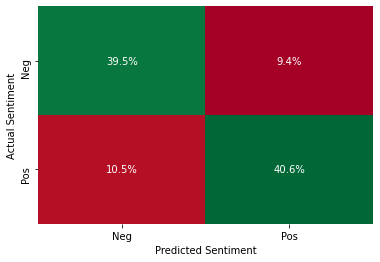

In [11]:
actual_vs_predictions_dict = {"Actual Sentiment": test_y, "Predicted Sentiment": model.predict(test_X)}
actual_vs_predictions_df = pd.DataFrame(actual_vs_predictions_dict)
confusion_matrix = pd.crosstab(actual_vs_predictions_df["Actual Sentiment"], actual_vs_predictions_df["Predicted Sentiment"])
sn.heatmap(confusion_matrix/len(test_X), annot=True, fmt=".1%", cbar=False, cmap="RdYlGn")
plt.show()

## Alternative 

Having run our model we can now look at a potential alternative, an n-gram model. This simply means that rather than considering each word independently (this is a unigram model, ie n=1), we consider groups of n words. Conceptually this means that we are considering each word as conditionally dependent on the previous n-1 words. This makes sense intuitively of course, as clearly words are not conditionally independent of each other. In the context of car reviews, we would expect multiple words to impart more meaning than just single words taken independently. For example, the trigram "not very impressive" is likely intended to impart negative sentiment, whereas taken seperately "not", "very" and "impressive" could indicate positive sentiment. So we may expect the model to have more predictive power than a unigram model.

N-gram models are used extensively in natural language processing algorithms, and tend to work well in spam detection, sentiment analysis and other classification problems involving natural language (Russell & Norvig, Artificial Intelligence: A Modern Approach (Fourth Edition), p.826).

The code below defines a function to test different n-gram lengths in the same Naive Bayes model. Helpfully scikit-learn's CountVectorizer allows the ngram size to be passed in as an argument:

In [16]:
alternative_model_training_data = all_data.sample(n=training_data_size, random_state=1)
alternative_model_testing_data = all_data.drop(part_2_training_data.index)

def n_gram_NB(ngram_tuple, training_data, testing_data):
    vectorizer = CountVectorizer(ngram_range=ngram_tuple)
    train_X = vectorizer.fit_transform(training_data["Review"])
    train_X = pd.DataFrame(train_X.toarray(), columns=vectorizer.get_feature_names())
    train_y = training_data["Sentiment"]

    model = MultinomialNB(alpha=1.0)
    model.fit(train_X, train_y)
    
    test_X = vectorizer.transform(testing_data["Review"]).toarray()
    test_y = testing_data["Sentiment"]

    accuracy = model.score(test_X, test_y)
    actual_vs_predictions_dict = {"Actual Sentiment": test_y, "Predicted Sentiment": model.predict(test_X)}
    actual_vs_predictions_df = pd.DataFrame(actual_vs_predictions_dict)
    confusion_matrix = pd.crosstab(actual_vs_predictions_df["Actual Sentiment"], 
                                   actual_vs_predictions_df["Predicted Sentiment"])
    heatmap = sn.heatmap(confusion_matrix/len(test_X), annot=True, fmt=".1%", cbar=False, cmap="RdYlGn")
    
    return accuracy, heatmap

First we implement a bigram model (n=2):

0.782608695652174

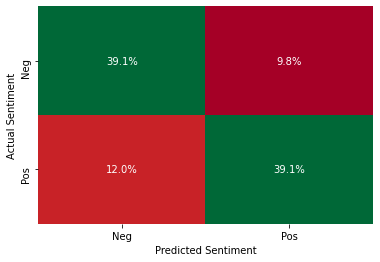

In [17]:
bigram_accuracy, bigram_heatmap = n_gram_NB((2, 2), alternative_model_training_data, alternative_model_testing_data)
bigram_accuracy

Then a trigram (n=3)

0.677536231884058

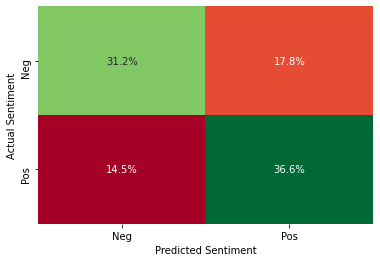

In [18]:
trigram_accuracy, trigram_heatmap = n_gram_NB((3, 3), part_2_training_data, part_2_testing_data)
trigram_accuracy

Comparing these with our initial results (which is possible as the same training and testing data split has been maintained), it is clear that increasing the value of n does not lead to an improved model, in fact the model predictions are getting less accurate as n increases. This may be due to the higher variance of bigram and trigram models. There are many more unique combinations of 2 or 3 words than there are single words, and given the fairly small dataset used here, it's likely that there are not enough instances of particular 2 or 3 word groups to correlate with positive or negative sentiment. 

The advantage of bigram and trigram models is that they do not exibit the same bias as unigram models, where particular words may be identified as contributing strongly to positive or negative sentiment purely because they happen to exist in a larger proportion in one class in the training set, rather than because they are actual sentiment affecting words. This is much less likely to happen in higher ngram models. Either larger datasets, or more rigorous pre-processing to remove non-sentiment-affecting language will be required to overcome the variance here.